<a href="https://colab.research.google.com/github/om-varshney/Melody-GAN/blob/main/GAN_SEM_VI_AudioGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pydub

In [ ]:
#@title Download Embeddings
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 22.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
#@title Imports
import uuid
import random
import os
import glob

import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
from pydub import AudioSegment
import librosa
import matplotlib.pyplot as plt

In [ ]:
#@title Constants
SAMPLING_RATE = 16_000
EMBEDDING_DIR = "/content/drive/MyDrive/GAN/embeddings_spacy/"
LATENT_DIM = 300
EPOCHS = 100
DURATION = 4
OUTPUT_SHAPE = INPUT_SHAPE = SAMPLING_RATE * DURATION
BATCH_SIZE = 32
DATA_FOLDER = "/content/drive/MyDrive/GAN/resampled/**/*.wav"
LEARNING_RATE = 2e-4

In [ ]:
#@title In Memory Objects
embedding_files = sorted(glob.glob(os.path.join(EMBEDDING_DIR, "*.npy")))
embeddings = [np.load(f) for f in embedding_files]

In [ ]:
au = AudioDataset()
print(au[0])
au.__getitem__(0)

In [ ]:
#@title Helper
def get_random_embedding_batch():
    # Select a random subset from the embeddings list
    return np.array(random.sample(embeddings, BATCH_SIZE))


class AudioDataset(tf.keras.utils.Sequence):
    def __init__(self, data_folder=DATA_FOLDER, batch=BATCH_SIZE):
        self.data_folder = data_folder
        self.file_list = list(glob.glob(data_folder, recursive=True))
        self.batch_size = batch

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, idx):
        batch_files = self.file_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_audio = []
        for file_name in batch_files:
            audio, _ = librosa.load(file_name, sr=SAMPLING_RATE, duration=DURATION)
            batch_audio.append(audio)
        return np.array(batch_audio)

In [ ]:
#@title Generator
class Generator(Model):
    def __init__(self, ldim=LATENT_DIM, out_shape=OUTPUT_SHAPE):
        super(Generator, self).__init__()
        self.latent_dim = ldim

        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(ldim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.BatchNormalization(momentum=0.9),
            tf.keras.layers.Reshape((32, 1)),
            tf.keras.layers.Conv1D(filters=64, kernel_size=50, padding='same', activation='relu'),
            tf.keras.layers.Conv1D(filters=64, kernel_size=100, padding='same', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(out_shape, activation='tanh')
        ])

    def call(self, inputs):
        return self.model(inputs)

In [ ]:
#@title Discriminator
class Discriminator(Model):
    def __init__(self, in_shape=INPUT_SHAPE):
        super(Discriminator, self).__init__()

        self.model = tf.keras.Sequential([
            tf.keras.layers.Reshape((in_shape, 1), input_shape=(in_shape,)),
            tf.keras.layers.Conv1D(32, 100, activation='relu'),
            tf.keras.layers.Conv1D(16, 50, activation='relu'),
            tf.keras.layers.Conv1D(8, 25, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ])

    def call(self, inputs):
        return self.model(inputs)

In [ ]:
#@title Pre-training initialization
generator = Generator()
discriminator = Discriminator()

# Define loss function and optimizers
loss_fn = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Configure data loader
dataset = AudioDataset()

# To save losses
gen_loss_history = []
dis_loss_history = []

In [ ]:
#@title Training
for epoch in range(EPOCHS):
    for i, real_audio_batch in enumerate(dataset):
        # Adversarial ground truths
        valid = np.ones((BATCH_SIZE, 1))
        fake = np.zeros((BATCH_SIZE, 1))

        # Flatten the audio batch
        real_audio_batch = real_audio_batch.reshape((BATCH_SIZE, -1))

        # -----------------
        #  Train Generator
        # -----------------

        with tf.GradientTape() as gen_tape:
            # Generate a batch of audio samples
            z = get_random_embedding_batch()
            gen_audio_batch = generator(z, training=True)

            # Measure discriminator's ability to classify generated samples
            validity = discriminator(gen_audio_batch, training=False)
            g_loss = loss_fn(valid, validity)

            gen_loss_history.append(g_loss.numpy())

        gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        with tf.GradientTape() as disc_tape:
            # Measure discriminator's ability to classify real samples
            real_pred = discriminator(real_audio_batch, training=True)
            d_real_loss = loss_fn(valid, real_pred)

            # Measure discriminator's ability to classify generated samples
            fake_pred = discriminator(gen_audio_batch, training=False)
            d_fake_loss = loss_fn(fake, fake_pred)

            d_loss = (d_real_loss + d_fake_loss) / 2

            dis_loss_history.append(d_loss.numpy())

        gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, EPOCHS, i, len(dataset), d_loss.numpy(), g_loss.numpy())
        )

[Epoch 0/100] [Batch 0/29] [D loss: 0.692664] [G loss: 0.693111]
[Epoch 0/100] [Batch 1/29] [D loss: 0.493809] [G loss: 0.554060]
[Epoch 0/100] [Batch 2/29] [D loss: 0.608292] [G loss: 0.388916]
[Epoch 0/100] [Batch 3/29] [D loss: 0.683123] [G loss: 0.355670]
[Epoch 0/100] [Batch 4/29] [D loss: 0.536447] [G loss: 0.506950]
[Epoch 0/100] [Batch 5/29] [D loss: 0.412401] [G loss: 0.666952]
[Epoch 0/100] [Batch 6/29] [D loss: 0.378218] [G loss: 0.673521]
[Epoch 0/100] [Batch 7/29] [D loss: 0.449902] [G loss: 0.536213]
[Epoch 0/100] [Batch 8/29] [D loss: 0.473438] [G loss: 0.500061]
[Epoch 0/100] [Batch 9/29] [D loss: 0.496742] [G loss: 0.573393]
[Epoch 0/100] [Batch 10/29] [D loss: 0.474555] [G loss: 0.577117]
[Epoch 0/100] [Batch 11/29] [D loss: 0.625311] [G loss: 0.370942]
[Epoch 0/100] [Batch 12/29] [D loss: 0.567370] [G loss: 0.425492]
[Epoch 0/100] [Batch 13/29] [D loss: 0.476221] [G loss: 0.659162]
[Epoch 0/100] [Batch 14/29] [D loss: 0.472138] [G loss: 0.507197]
[Epoch 0/100] [Batch

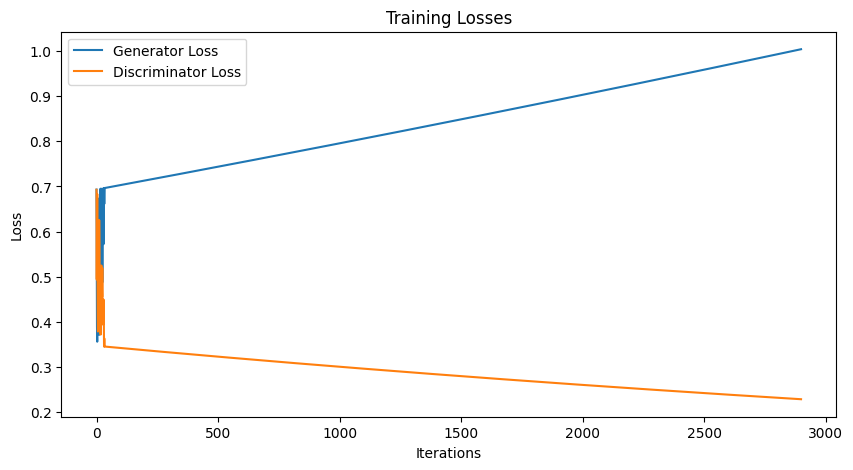

In [ ]:
#@title Plot Gen/Dis loss
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_history, label='Generator Loss')
plt.plot(dis_loss_history, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

In [ ]:
#@title Save trained models
generator.save('/content/drive/MyDrive/GAN/generator_model', save_format='tf')
discriminator.save('/content/drive/MyDrive/GAN/discriminator_model', save_format='tf')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Enter your text: Dream World


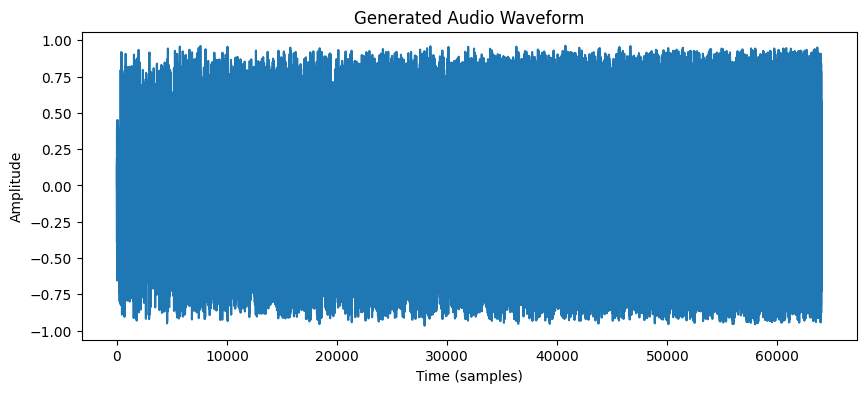

In [ ]:
import tensorflow as tf
import numpy as np
import spacy
import uuid
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Load the trained models
generator = tf.keras.models.load_model('/content/drive/MyDrive/GAN/generator_model')

# Load the spaCy model
nlp = spacy.load('en_core_web_md')

# Get user input text
text = input("Enter your text: ")

# Generate embedding using spaCy
embedding = nlp(text).vector

# Reshape the embedding to match the generator input
embedding = embedding.reshape(1, -1)

# Generate audio from the embedding
generated_audio = generator(embedding, training=False)[0]

# Reshape the audio if needed (ensure the shape is correct for your use case)
generated_audio = generated_audio.numpy()

# Play the generated audio within the notebook
# Note: The audio object expects a one-dimensional array for playback
# You might need to adjust the sample rate and other parameters to match your audio generation
audio_for_display = Audio(generated_audio.flatten(), rate=SAMPLING_RATE)
display(audio_for_display)

# Display the generated audio waveform
plt.figure(figsize=(10, 4))
plt.plot(generated_audio)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Generated Audio Waveform')
plt.show()